In Natural Language Processing (NLP), Entity Recognition is one of
the common problems. NER is a method of extracting the relevant
information from a large corpus and classifying those entities into
predefined categories such as location, organization, name, and so
on.
In this problem you are given tagged data for entities, you have to
predict those entities using LSTM models.

## Importing Libraries

In [34]:
# Importing the libraries
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
##from tensorflow.keras.models import Sequential
##from tensorflow.keras.layers import Dense, LSTM, Dropout, GRU, Bidirectional,SimpleRNN
##from tensorflow.keras.optimizers import SGD
import math
from sklearn.metrics import mean_squared_error
from keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
from tensorflow.keras import Model, Input
from tensorflow.keras.layers import LSTM, Embedding, Dense
from tensorflow.keras.layers import TimeDistributed, SpatialDropout1D, Bidirectional



## Importing Dataset

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
!ls -ltr "/content/drive/My Drive/Dataset/Seq_Learn_Assign_2"

total 6477
-rw------- 1 root root 6478648 Apr 14  2020 CRF_POS_dataset.csv
-rw------- 1 root root  153466 Dec 29 01:37 IBM_2006-01-01_to_2018-01-01.csv


In [4]:
data = pd.read_csv('/content/drive/My Drive/Dataset/Seq_Learn_Assign_2/CRF_POS_dataset.csv',encoding='cp1252')
data.head()

,Num,Word,Tag_POS
0,1.0,A,DT
1,NaN,37-year-old,JJ
2,NaN,woman,NN
3,NaN,has,VBZ
4,NaN,become,VBN


## Data Preprocessing

In [5]:
## Forward filling the data whereever there is null value
data = data.fillna(method='ffill')

In [6]:
data.head()

,Num,Word,Tag_POS
0,1.0,A,DT
1,1.0,37-year-old,JJ
2,1.0,woman,NN
3,1.0,has,VBZ
4,1.0,become,VBN


In [7]:
## Getting unique counts
print("Unique words in corpus:", data['Word'].nunique())
print("Unique tags in corpus:", data['Tag_POS'].nunique())

Unique words in corpus: 26398
Unique tags in corpus: 42


In [8]:
## Creating a set of unique words
words = list(set(data["Word"].values))
words.append("ENDPAD")
num_words = len(words)
print('Number of Unique words:', num_words)

Number of Unique words: 26399


In [9]:
## Creating a unique set of Tags
tags = list(set(data["Tag_POS"].values))
num_tags = len(tags)
print('Number of Unique Tags:', num_tags)

Number of Unique Tags: 42


Group the data to find relationship between sentences and tags

In [11]:
grp_func = lambda s: [(w, p) for w, p in zip(s['Word'].values.tolist(), 
                                                    s['Tag_POS'].values.tolist())]
data_grped = data.groupby('Num').apply(grp_func)
sentence = [s for s in data_grped]
data_grped.head()

Num
1.0    [(A, DT), (37-year-old, JJ), (woman, NN), (has...
2.0    [(Nadia, NNP), (Mohammed, NNP), (Abdel, NNP), ...
3.0    [(Health, NNP), (officials, NNS), (initially, ...
4.0    [(The, DT), (woman, NN), (raised, VBD), (poult...
5.0    [(Health, NNP), (officials, NNS), (announced, ...
dtype: object

In [12]:
print(type(sentence))
print(len(sentence))
print(sentence[0])

<class 'list'>
25929
[('A', 'DT'), ('37-year-old', 'JJ'), ('woman', 'NN'), ('has', 'VBZ'), ('become', 'VBN'), ('the', 'DT'), ('13th', 'JJ'), ('person', 'NN'), ('in', 'IN'), ('Egypt', 'NNP'), ('to', 'TO'), ('die', 'VB'), ('of', 'IN'), ('the', 'DT'), ('H5N1', 'NNP'), ('strain', 'NN'), ('of', 'IN'), ('bird', 'NN'), ('flu', 'NN'), ('.', '.')]


In [13]:
sentence[0]

[('A', 'DT'),
 ('37-year-old', 'JJ'),
 ('woman', 'NN'),
 ('has', 'VBZ'),
 ('become', 'VBN'),
 ('the', 'DT'),
 ('13th', 'JJ'),
 ('person', 'NN'),
 ('in', 'IN'),
 ('Egypt', 'NNP'),
 ('to', 'TO'),
 ('die', 'VB'),
 ('of', 'IN'),
 ('the', 'DT'),
 ('H5N1', 'NNP'),
 ('strain', 'NN'),
 ('of', 'IN'),
 ('bird', 'NN'),
 ('flu', 'NN'),
 ('.', '.')]

### Defining mapping between sentences and tags

In [14]:
word2idx = {w: i + 1 for i, w in enumerate(words)}
tag2idx = {t: i for i, t in enumerate(tags)}

In [15]:
word2idx

{'irresponsibly': 1,
 'Sideways': 2,
 'armed': 3,
 '7.9': 4,
 'Wednesday': 5,
 'Strikes': 6,
 'CHILUBA': 7,
 'profile': 8,
 'DUHALDE': 9,
 'unused': 10,
 'apparently': 11,
 'rain-interrupted': 12,
 'escalation': 13,
 'crash': 14,
 'one-on-one': 15,
 'Nations-hosted': 16,
 'contractors': 17,
 'Dae': 18,
 'Secretariat': 19,
 'Esteban': 20,
 'Waters': 21,
 'shed': 22,
 'zealous': 23,
 '373': 24,
 'Exact': 25,
 'Andrey': 26,
 'unstable': 27,
 'mother': 28,
 'Prize-winning': 29,
 'hairless': 30,
 'generic': 31,
 'Characterized': 32,
 'petitions': 33,
 'Katsav': 34,
 'misused': 35,
 'idol': 36,
 'bicameral': 37,
 'Remissaninthe': 38,
 '215': 39,
 'regency': 40,
 'acquaint': 41,
 'films': 42,
 'Moustafa': 43,
 'Nath': 44,
 'Issa': 45,
 'academics': 46,
 'blasts': 47,
 'existed': 48,
 'strengthens': 49,
 'pedestrians': 50,
 'brigades': 51,
 'Winning': 52,
 'Bogra': 53,
 'complicating': 54,
 'Iraqiya': 55,
 'comes': 56,
 'Thien': 57,
 'Arroyo': 58,
 'Kashmiri': 59,
 'curbed': 60,
 'SHIPWRECKED'

In [16]:
tag2idx

{'$': 0,
 ',': 40,
 '.': 34,
 ':': 5,
 ';': 1,
 'CC': 21,
 'CD': 13,
 'DT': 2,
 'EX': 37,
 'FW': 38,
 'IN': 18,
 'JJ': 14,
 'JJR': 17,
 'JJS': 26,
 'LRB': 28,
 'MD': 15,
 'NN': 33,
 'NNP': 25,
 'NNPS': 22,
 'NNS': 12,
 'PDT': 36,
 'POS': 8,
 'PRP': 7,
 'PRP$': 6,
 'RB': 41,
 'RBR': 10,
 'RBS': 32,
 'RP': 16,
 'RRB': 11,
 'TO': 35,
 'UH': 27,
 'VB': 4,
 'VBD': 23,
 'VBG': 29,
 'VBN': 9,
 'VBP': 24,
 'VBZ': 19,
 'WDT': 39,
 'WP': 20,
 'WP$': 30,
 'WRB': 31,
 '``': 3}

In [21]:
## max length of word
max_len = max([len(s) for s in words])
max_len

26

## Training the dataset

### Preparing dataset for training

In [27]:
# Creating X data from each sentance for words
X = [[word2idx[w[0]] for w in s] for s in sentence]

# Padding for each sequence basis on max length of word
X = pad_sequences(maxlen=max_len, sequences=X, padding="post", value=num_words-1)


# Creating y data from each sentances for Tags
y = [[tag2idx[w[1]] for w in s] for s in sentence]

# Padding for each sequence basis on max length of word
y = pad_sequences(maxlen=max_len, sequences=y, padding="post", value=0)

In [28]:
X

array([[11270,  7223, 16790, ..., 26398, 26398, 26398],
       [ 5376, 18008,  2643, ..., 26398, 26398, 26398],
       [ 8272, 16215, 19289, ..., 26398, 26398, 26398],
       ...,
       [ 3841, 14991, 11061, ..., 26398, 26398, 26398],
       [10452,  7348, 20795, ..., 26398, 26398, 26398],
       [14371,  9669,  6750, ..., 26398, 26398, 26398]], dtype=int32)

In [30]:
y

array([[ 2, 14, 33, ...,  0,  0,  0],
       [25, 25, 25, ...,  0,  0,  0],
       [25, 12, 41, ...,  0,  0,  0],
       ...,
       [13, 17, 23, ...,  0,  0,  0],
       [ 7, 24, 41, ...,  0,  0,  0],
       [14, 12, 23, ...,  0,  0,  0]], dtype=int32)

In [33]:
## Test Train Split
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=40)

### Building Bi-directional LSTM Model

In [35]:
input_word = Input(shape=(max_len,))
model = Embedding(input_dim=num_words, output_dim=140, input_length=max_len)(input_word)
model = SpatialDropout1D(0.2)(model)
model = Bidirectional(LSTM(units=100, return_sequences=True, recurrent_dropout=0.1))(model)
out = TimeDistributed(Dense(num_tags, activation="softmax"))(model)
model = Model(input_word, out)
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 26)]              0         
                                                                 
 embedding (Embedding)       (None, 26, 140)           3695860   
                                                                 
 spatial_dropout1d (SpatialD  (None, 26, 140)          0         
 ropout1D)                                                       
                                                                 
 bidirectional (Bidirectiona  (None, 26, 200)          192800    
 l)                                                              
                                                                 
 time_distributed (TimeDistr  (None, 26, 42)           8442      
 ibuted)                                                         
                                                             

Compiling the model

In [36]:
model.compile(optimizer="adam",
              loss="sparse_categorical_crossentropy",
              metrics=["accuracy"])

In [37]:
## Training the model

history = model.fit(
    x=x_train,
    y=y_train,
    validation_data=(x_test,y_test),
    batch_size=32, 
    epochs=4,
    verbose=1
)

Epoch 1/4
649/649 [==============================] - 100s 144ms/step - loss: 0.7297 - accuracy: 0.8115 - val_loss: 0.1064 - val_accuracy: 0.9708
Epoch 2/4
649/649 [==============================] - 92s 142ms/step - loss: 0.0639 - accuracy: 0.9820 - val_loss: 0.0739 - val_accuracy: 0.9770
Epoch 3/4
649/649 [==============================] - 91s 141ms/step - loss: 0.0346 - accuracy: 0.9891 - val_loss: 0.0715 - val_accuracy: 0.9780
Epoch 4/4
649/649 [==============================] - 92s 141ms/step - loss: 0.0252 - accuracy: 0.9918 - val_loss: 0.0705 - val_accuracy: 0.9788


### Plotting model's accuracy

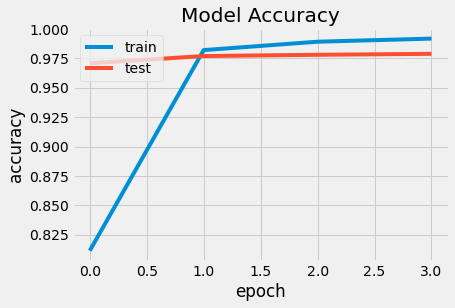

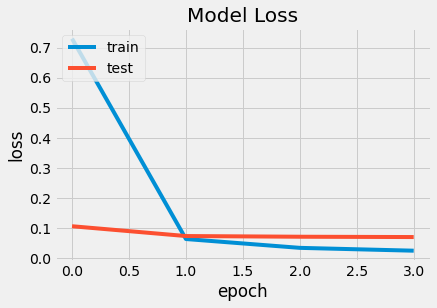

In [38]:
import matplotlib.pyplot as plt

plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [43]:
res = model.evaluate(x_test, y_test)
print('Loss:',round(res[0],4))
print('Accuracy:',round(res[1],4))

163/163 [==============================] - 3s 16ms/step - loss: 0.0705 - accuracy: 0.9788
Loss: 0.0705
Accuracy: 0.9788


## Predicting using model

In [40]:
i = np.random.randint(0, x_test.shape[0]) #659

pred = model.predict(np.array([x_test[i]]))

pred = np.argmax(pred, axis=-1)
y_true = y_test[i]
print("{:15}{:5}\t {}\n".format("Word", "True", "Pred"))
print("-" *30)
for w, true, predic in zip(x_test[i], y_true, pred[0]):
    if tags[true] != 'O' and tags[predic] != 'O':
        print("{:15}{}\t{}".format(words[w-1], tags[true], tags[predic]))

Word           True 	 Pred

------------------------------
Separately     RB	RB
,              ,	,
two            CD	CD
protesters     NNS	NNS
were           VBD	VBD
killed         VBN	VBN
Sunday         NNP	NNP
when           WRB	WRB
police         NNS	NNS
opened         VBD	VBD
fire           NN	NN
on             IN	IN
a              DT	DT
similar        JJ	JJ
demonstration  NN	NN
in             IN	IN
eastern        JJ	JJ
Logar          NNP	NNP
province       NN	NN
.              .	.
Cannes         $	$
Cannes         $	$
Cannes         $	$
Cannes         $	$
Cannes         $	$
Cannes         $	$


The model has an accuracy of 98.88%